In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pyp
from skimage import io, data

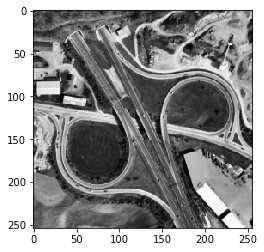

In [2]:
# Reading an image
image = io.imread("autopista.tif", as_gray=True)
plt.imshow(image, cmap="gray")

In [3]:
def resize_image(image, padding):
    """
    This function lets you resize an image for working with some operations that require
    adding (or extend) the borders of the input image, specially for Convolution and
    Binarization methods like Niblack's and Sauvola's.
    Returns the image resized.
    """
    image_height, image_width = image.shape
    new_image_height, new_image_width = 2 * padding + image_height, 2 * padding + image_width
    new_image = np.zeros((new_image_height, new_image_width))
    
    # Copy the original image at the center of the new extended image.
    new_image[padding:new_image_height - padding, padding:new_image_width - padding] = image
    
    # Get all borders
    image_left_border = np.array([image[:,0]]).T
    image_right_border = np.array([image[:,-1]]).T
    image_top_border = image[0,:]
    image_bottom_border = image[-1,:]
    
    # Get all corners
    # LT : Left-Top    | RT : Right-Top
    # LB : Left-Bottom | RB : Right-Bottom
    image_lt_corner = np.array([image[0,0]])
    image_rt_corner = np.array([image[0,-1]])
    image_lb_corner = np.array([image[-1,0]])
    image_rb_corner = np.array([image[-1,-1]])
    
    # Copy the left border
    new_image[padding:image_height + padding,
              0:padding] = np.tile(image_left_border, (1, padding))
    
    # Copy the right border
    new_image[padding:image_height + padding,
              image_width + padding:new_image_width] = np.tile(image_right_border, (1, padding))
    
    # Copy the top border
    new_image[0:padding,
              padding:image_width + padding] = np.tile(image_top_border, (padding, 1))

    # Copy the bottom border
    new_image[image_height + padding:new_image_height,
              padding:image_width + padding] = np.tile(image_bottom_border, (padding, 1))
    
    # Copy the corners
    new_image[0:padding, 0:padding] = np.tile(image_lt_corner, (padding, padding))
    new_image[0:padding, image_width + padding:new_image_width] = np.tile(image_rt_corner, (padding, padding))
    new_image[image_height + padding:new_image_height, 0:padding] = np.tile(image_lb_corner, (padding, padding))
    new_image[image_height + padding:new_image_height, image_width + padding:new_image_width] = np.tile(image_rb_corner, (padding, padding))
    
    return new_image

def convolve(image, kernel):
    image_height, image_width = image.shape
    kernel_height, kernel_width = kernel.shape
    padding = kernel_width // 2
    
    # Check if kernel dimensions are an odd number
    if kernel_width % 2 == 0: return None
    
    # Extending borders and generating output image matrix
    temporal_image = resize_image(image, padding)
    output_image = np.zeros((image_height, image_width), dtype=np.dtype(np.int32))
    
    # Iterating over the rows and columns of the extended image
    for i in np.arange(padding, image_height + padding):
        for j in np.arange(padding, image_width + padding):
            
            # Iterating over the sections of the original image that will be convolved with
            # the given kernel. The size of the section depends directly from the size of the
            # kernel. After the convolution is performed, the result will be stored in the
            # corresponding position of the output image matrix.
            image_section = temporal_image[i - padding:i + (padding + 1), j - padding:j + (padding + 1)]
            convolution = int(np.sum(np.multiply(image_section, kernel)))
            output_image[i - padding, j - padding] = convolution
    return output_image

def diffusion_coefficient(gradient_value, K, option = 1):
    if option == 1: return np.exp(-(gradient_value/K)**2)
    elif option == 2: return 1 / (1 + (gradient_value/K)**2)
    else: return None
    
def anisotropic_diffusion(image, steps, K, _lambda = 0.25, diff_coef = 1):
    #new_image = np.zeros(image.shape, dtype=image.dtype)
    new_image = np.copy(image)
    for t in np.arange(steps):
        extended_image = resize_image(new_image, padding=1)
        difference_north = extended_image[:-2, 1:-1] - extended_image[1:-1, 1:-1]
        difference_south = extended_image[2:, 1:-1] - extended_image[1:-1, 1:-1] 
        difference_east = extended_image[1:-1, 2:] - extended_image[1:-1, 1:-1] 
        difference_west = extended_image[1:-1, :-2] - extended_image[1:-1, 1:-1]
        new_image = new_image + _lambda * \
                    (diffusion_coefficient(difference_north, K, diff_coef) * difference_north + \
                     diffusion_coefficient(difference_south, K, diff_coef) * difference_south + \
                     diffusion_coefficient(difference_east, K, diff_coef) * difference_east + \
                     diffusion_coefficient(difference_west, K, diff_coef) * difference_west)
    return new_image

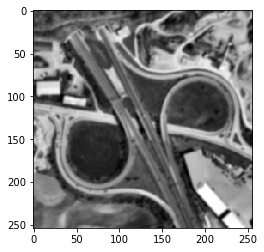

In [4]:
gaussian_kernel = 1/273 * np.array([[1,4,7,4,1],
                           [4,16,26,16,4],
                           [7,26,41,26,7],
                           [4,16,26,16,4],
                           [1,4,7,4,1]])


a = convolve(image, gaussian_kernel)
plt.imshow(a, cmap='gray')

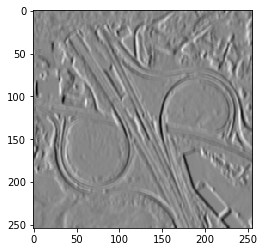

In [5]:
kernel_detector_bordes = np.array([[1,2,0,-2,-1]]*5)
a = convolve(image, kernel_detector_bordes)
plt.imshow(a, cmap='gray')

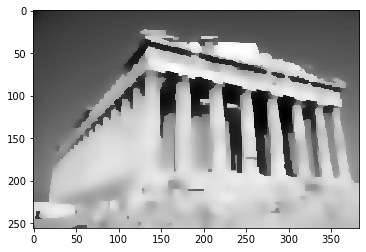

In [39]:
image = io.imread("0.png", as_gray=True)
im2 = anisotropic_diffusion(image, 150, K = 8, _lambda = 0.15, diff_coef = 2)
pyp.figure('Image AFTER Perona-Malik anisotropic diffusion')
pyp.imshow(im2, cmap='gray')
pyp.axis('on')


pyp.show() #Display image